In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('ijcai2016_taobao_1.csv', sep=r',', engine='python')

In [4]:
df.head()

,use_ID,sel_ID,ite_ID,cat_ID,act_ID,time
0,1980536,9666,1450952,1,0,20150826
1,1980536,9666,1450952,1,0,20150826
2,647747,9666,1450952,1,0,20150915
3,1980536,9666,1450952,1,0,20150823
4,183647,9525,578730,1,0,20150711


In [5]:
df.describe().apply(lambda s: s.apply('{0}'.format))

,use_ID,sel_ID,ite_ID,cat_ID,act_ID,time
count,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0
mean,1024665.8052680527,4550.214902149021,1203661.2412924129,1.0,0.1009310093100931,20150830.19217192
std,596919.0583544845,2805.703221327739,688457.0158119791,0.0,0.3012388556068006,116.58427140128536
min,13.0,60.0,2017.0,1.0,0.0,20150701.0
25%,505223.0,2258.0,594459.0,1.0,0.0,20150720.0
50%,1023194.0,4562.0,1250255.0,1.0,0.0,20150813.0
75%,1542806.0,6792.0,1784092.0,1.0,0.0,20150916.0
max,2063567.0,9995.0,2353171.0,1.0,1.0,20151130.0


In [6]:
data_click = df[['use_ID', 'ite_ID', 'act_ID']].loc[df['act_ID'] == 0]
data_click = data_click.drop_duplicates()

In [7]:
data_buy = df[['use_ID', 'ite_ID', 'act_ID']].loc[df['act_ID'] == 1]
data_buy = data_buy.drop_duplicates()

In [8]:
data_merge = pd.merge(data_click, data_buy, left_on=['use_ID','ite_ID'], right_on=['use_ID','ite_ID'], how = 'left')
data_merge.columns = ['use_ID', 'ite_ID', 'click', 'buy']
data_merge['click'] = data_merge['click'].replace(0, 1)
data_merge['buy'] = data_merge['buy'].fillna(0)

data_merge.head()

,use_ID,ite_ID,click,buy
0,1980536,1450952,1,0.0
1,647747,1450952,1,0.0
2,183647,578730,1,0.0
3,723956,28301,1,0.0
4,1781938,28301,1,0.0


In [9]:
data_click.shape , data_buy.shape, data_merge.shape

((66802, 3), (8391, 3), (66802, 4))

In [10]:
data_merge.loc[data_merge['buy'] == 0].shape, data_merge.loc[data_merge['buy'] == 1].shape

((64808, 4), (1994, 4))

In [11]:
msk = np.random.rand(len(data_merge)) < 0.8
train = data_merge[msk]
test = data_merge[~msk]

In [12]:
train.shape, test.shape

((53346, 4), (13456, 4))

In [30]:
x_train = train.iloc[:, 0:-2].values
y_train = train.iloc[:,2:4].values

# x_train = np.expand_dims(x_train, axis=1)
# y_train = np.expand_dims(y_train, axis=1)

x_test = test.iloc[:, 0:-2].values
y_test = test.iloc[:,2:4].values

# x_test = np.expand_dims(x_test, axis=1)
# y_test = np.expand_dims(y_test, axis=1)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((53346, 2), (53346, 2), (13456, 2), (13456, 2))

In [14]:
num_users = 2353171+1
num_items = 2353171+1

In [15]:
num_users, num_items

(2353172, 2353172)

In [36]:
from keras.layers import Embedding, Input, Dense, merge, Reshape, Flatten, Dropout
from keras.regularizers import l2
from keras.optimizers import Adagrad, Adam, SGD, RMSprop

layers = [20,10]
reg_layers=[0,0]
num_layer = len(layers)
learning_rate = 10e-4

## Tạo lớp input kích thước (None, 32, 32, 1)
inputs = tf.keras.layers.Input(shape=(2))

Embedding_User = Embedding(
    input_dim = num_users, 
    output_dim = 64, name = 'user_embedding',
    embeddings_initializer = 'uniform', embeddings_regularizer = l2(reg_layers[0]), input_length=None, trainable=False)

Embedding_Item = Embedding(
    input_dim = num_items, 
    output_dim = 64, 
    name = 'item_embedding',
    embeddings_initializer = 'uniform', embeddings_regularizer = l2(reg_layers[0]), input_length=None, trainable=False)

user_embedding = Embedding_User(inputs[:,0])
item_embedding = Embedding_Item(inputs[:,1])

user_latent = Flatten(name = 'user_latent')(user_embedding)
item_latent = Flatten(name = 'item_latent')(item_embedding)

vector = tf.keras.layers.Multiply()([user_latent, item_latent])

user_embedding2 = Embedding_User(inputs[:,0])
item_embedding2 = Embedding_Item(inputs[:,1])

user_latent2 = Flatten(name = 'user_latent2')(user_embedding2)
item_latent2 = Flatten(name = 'item_latent2')(item_embedding2)

vector2 = tf.keras.layers.Multiply()([user_latent2, item_latent2])

# for idx in range(0, num_layer):
#     layer = Dense(layers[idx], kernel_regularizer= l2(reg_layers[idx]), activation='relu', name = 'layer_1_%d' %idx)
#     vector = layer(vector)

click_prediction = Dense(1, activation='sigmoid',use_bias=True, 
                         kernel_initializer='lecun_uniform', 
                         name = 'click_prediction')(vector)

buy_prediction = Dense(1, activation='sigmoid',use_bias=True, 
                         kernel_initializer='lecun_uniform', 
                         name = 'buy_prediction')(vector2)

outputs = tf.concat([click_prediction, buy_prediction], -1)

In [37]:
## Compile model
# with strategy.scope():
model = keras.models.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adagrad(lr=learning_rate), loss='binary_crossentropy', 
              metrics=["accuracy","mse",tf.keras.metrics.RootMeanSquaredError()])

In [38]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice_10 (T [(None,)]            0           input_5[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_strided_slice_11 (T [(None,)]            0           input_5[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_strided_slice_12 (T [(None,)]            0           input_5[0][0]                    
____________________________________________________________________________________________

In [39]:
history = model.fit(x_train, y_train, batch_size=200, epochs=100)

Epoch 1/100
267/267 [==============================] - 0s 740us/step - loss: 0.6840 - accuracy: 0.9974 - mse: 0.2454 - root_mean_squared_error: 0.4954
Epoch 2/100
267/267 [==============================] - 0s 736us/step - loss: 0.6755 - accuracy: 1.0000 - mse: 0.2412 - root_mean_squared_error: 0.4911
Epoch 3/100
267/267 [==============================] - 0s 736us/step - loss: 0.6700 - accuracy: 1.0000 - mse: 0.2384 - root_mean_squared_error: 0.4883
Epoch 4/100
267/267 [==============================] - 0s 740us/step - loss: 0.6655 - accuracy: 1.0000 - mse: 0.2362 - root_mean_squared_error: 0.4860
Epoch 5/100
267/267 [==============================] - 0s 738us/step - loss: 0.6617 - accuracy: 1.0000 - mse: 0.2343 - root_mean_squared_error: 0.4840
Epoch 6/100
267/267 [==============================] - 0s 735us/step - loss: 0.6583 - accuracy: 1.0000 - mse: 0.2326 - root_mean_squared_error: 0.4823
Epoch 7/100
267/267 [==============================] - 0s 705us/step - loss: 0.6553 - accuracy

In [40]:
model.evaluate(x_test, y_test)

421/421 [==============================] - 0s 628us/step - loss: 0.5529 - accuracy: 1.0000 - mse: 0.1804 - root_mean_squared_error: 0.4247


[0.5528536438941956, 1.0, 0.18039967119693756, 0.42473483085632324]

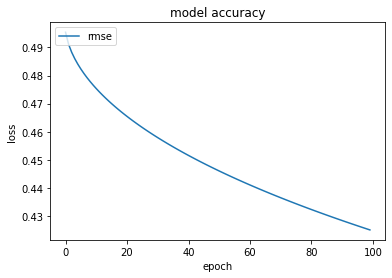

In [41]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['root_mean_squared_error'])
# plt.plot(history.history['loss'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['rmse'], loc='upper left')
plt.show()

In [42]:
x_train[0].shape

(2,)

In [43]:
y_pred = model.predict(x_train)
y_pred.shape

(53346, 2)

In [44]:
x_train.shape

(53346, 2)

In [49]:
x_train[1].shape

(2,)

In [46]:
x_input = np.expand_dims(x_train[0], axis=1)
x_input.shape

(2, 1)

In [50]:
model.predict(x_train[0:1])

array([[0.57831323, 0.42210636]], dtype=float32)

In [51]:
y_train[0:1]

array([[1., 0.]])